In [1]:
!pip install saliency

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.1 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import average_precision_score
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
from matplotlib import pylab as P
import PIL.Image
import saliency.core as saliency
from tqdm import tqdm

In [3]:


# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/Pneumothorax_Labels_Final.csv")
df = df.rename(columns={"label": "Target", "ImageId": "patientId"})
df2 = df[['Split', 'patientId', 'Target']]

# Separate positive class (Target = 1) rows from the dataframes
df_train_positive = df2[(df2['Split'] == 'train') & (df2['Target'] == 1)]
df_val_positive = df2[(df2['Split'] == 'val') & (df2['Target'] == 1)]
df_test_positive = df2[(df2['Split'] == 'test') & (df2['Target'] == 1)]

# Combine the dataframes into one
df_positive = pd.concat([df_train_positive, df_val_positive, df_test_positive], ignore_index=True)
df_positive = df_positive.drop(columns=['Split'])  # Remove the 'Split' column if it's not needed
df_positive = df_positive.reset_index(drop=True)

# Path Split
root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/images_png/PNG/train'

# Create a list of positive class image paths
positive_paths = [os.path.join(root, image) for image in df_positive['patientId']]

# Print the combined dataframe with positive class data and the list of paths
print(df_positive)
print(positive_paths)



                                              patientId  Target
0     1.2.276.0.7230010.3.1.4.8323329.10287.15178752...       1
1     1.2.276.0.7230010.3.1.4.8323329.10801.15178752...       1
2     1.2.276.0.7230010.3.1.4.8323329.11054.15178752...       1
3     1.2.276.0.7230010.3.1.4.8323329.31797.15178751...       1
4     1.2.276.0.7230010.3.1.4.8323329.4871.151787518...       1
...                                                 ...     ...
2371  1.2.276.0.7230010.3.1.4.8323329.10750.15178752...       1
2372  1.2.276.0.7230010.3.1.4.8323329.1586.151787516...       1
2373  1.2.276.0.7230010.3.1.4.8323329.3047.151787517...       1
2374  1.2.276.0.7230010.3.1.4.8323329.13041.15178752...       1
2375  1.2.276.0.7230010.3.1.4.8323329.1532.151787516...       1

[2376 rows x 2 columns]
['/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/images_png/PNG/train/1.2.276.0.7230010.3.1.4.8323329.10287.1517875222.997107', '/content/drive/MyDrive/Saliency Map Research 2023/Pneu

In [11]:

# Function to load saliency maps from .pt files and apply normalization
def load_saliency_map(file_path, percentile=99):
    saliency_map = torch.load(file_path)
    #saliency_map = saliency_map.numpy()  # Convert PyTorch tensor to NumPy array

    #NON XRAI

    # Perform the normalization
    #image_2d = np.sum(np.abs(saliency_map), axis=2)
    #vmax = np.percentile(image_2d, percentile)
    #vmin = np.min(image_2d)
    #image_normalized = np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

    # Convert the normalized 2D array back to PyTorch tensor
    #saliency_map_normalized = torch.tensor(image_normalized, dtype=torch.float32)

    #XRAI

    # Convert the normalized 2D array back to PyTorch tensor
    saliency_map = torch.tensor(saliency_map, dtype=torch.float32)

        # Convert the saliency map to a single-channel image and squeeze the singleton dimension
    saliency_map = torch.sum(saliency_map, dim=2, keepdim=True)
    saliency_map = torch.squeeze(saliency_map, dim=2)

    #saliency_map_normalized = saliency_map

    return saliency_map  # Move the tensor to the GPU


In [12]:

# Function to load ground truth masks from .png files and resize to match the saliency map
def load_ground_truth(file_path, label):
    file_name = f"{label}.png"
    full_file_path = os.path.join(file_path, file_name)
    ground_truth_mask = Image.open(full_file_path).convert("L")  # Convert to grayscale

    # Binarize the ground truth mask based on nonzero pixels
    ground_truth_mask = rint(np.array(ground_truth_mask))

    # Convert the ground truth mask to a PIL Image for resizing
    ground_truth_mask = Image.fromarray(ground_truth_mask)

    # Resize the ground truth mask to the target size (299, 299)
    target_size = (224, 224)
    ground_truth_mask = ground_truth_mask.resize(target_size, Image.ANTIALIAS)

    # Convert the resized ground truth mask back to a NumPy array
    return np.array(ground_truth_mask)

# Function to extract label from saliency map file name
def extract_label_saliency_map(file_name):
    return file_name.split("_")[0]

# Function to binarize mask based on nonzero pixels
def rint(mask):
    mask[mask != 0] = 1
    return mask

# Function to extract label from ground truth mask file name
def extract_label_mask(file_name):
    return file_name.split(".")[0]


In [13]:

def auprc(smap, bb_mask):
    # Flatten the saliency map and ground truth mask to 1D arrays
    smap_flat = smap.flatten()
    bb_mask_flat = bb_mask.flatten()

    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(bb_mask_flat, smap_flat)

    # Calculate AUPRC using trapezoidal rule
    auprc_val = auc(recall, precision)

    return auprc_val


In [14]:

# Define the parent directory containing folders of saliency maps
parent_dir = "/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)"

# Get a list of subfolders (each folder represents a technique)
technique_folders = [folder for folder in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, folder))]


In [15]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:

technique_folders = ['Grad', 'Smooth Grad','IG','Smooth IG', 'Guided Backprop']
technique_folders

['Grad', 'Smooth Grad', 'IG', 'Smooth IG', 'Guided Backprop']

In [17]:

def display_images(saliency_map, ground_truth_mask, mean_auprc):
    # Move the saliency map tensor to CPU
    saliency_map_cpu = saliency_map.cpu()

    # Convert the tensors to numpy arrays
    saliency_map_np = saliency_map_cpu.detach().numpy()
    ground_truth_mask_np = ground_truth_mask

    # Display the saliency map and ground truth mask side by side
    plt.figure(figsize=(12, 6))  # Adjust figure size

    # Display the saliency map
    plt.subplot(1, 2, 1)
    plt.imshow(saliency_map_np, cmap='plasma')
    plt.title('Saliency Map')
    plt.axis('off')  # Remove axes and ticks

    # Display the ground truth mask
    plt.subplot(1, 2, 2)
    plt.imshow(ground_truth_mask_np, cmap='plasma')
    plt.title('Ground Truth Mask')
    plt.axis('off')  # Remove axes and ticks

    # Add the mean AUPRC to the title
    plt.suptitle(f"Mean AUPRC: {mean_auprc:.4f}", fontsize=14, y=1.05)

    plt.show()


Technique Folder: Grad


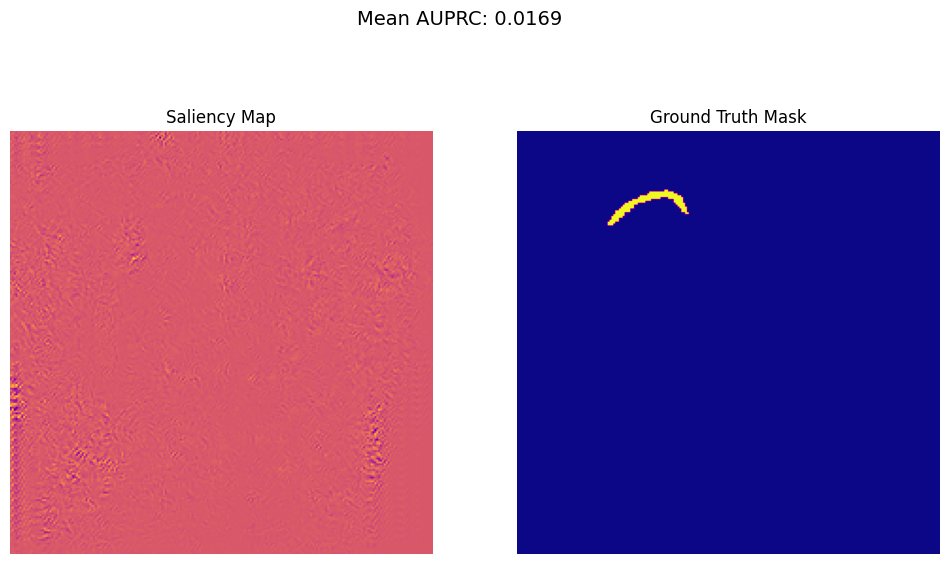

Mean AUPRC (Grad): 0.01693733476907266
Standard Deviation (SD) AUPRC (Grad): 0.018274287684445917

Technique Folder: Smooth Grad


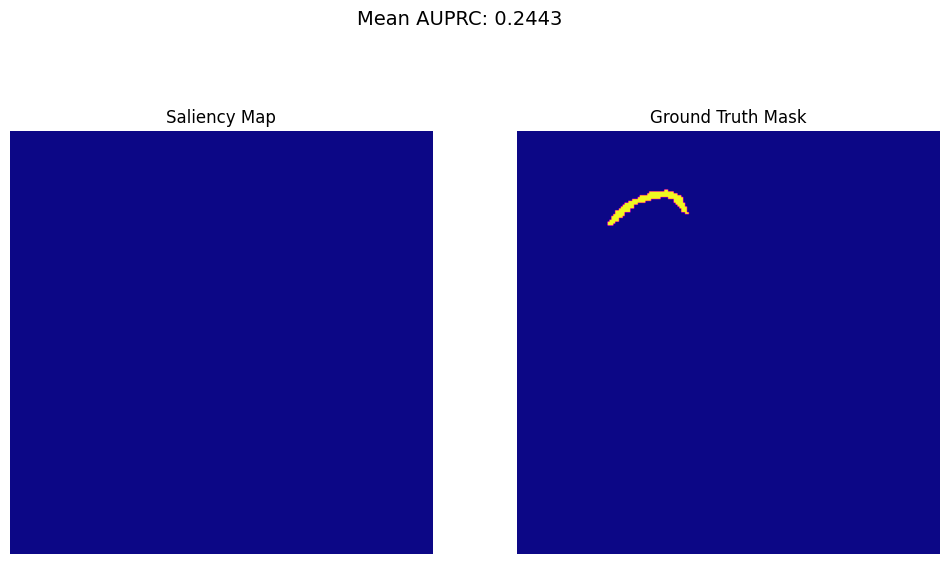

Mean AUPRC (Smooth Grad): 0.24430823832226556
Standard Deviation (SD) AUPRC (Smooth Grad): 0.244554605095385

Technique Folder: IG


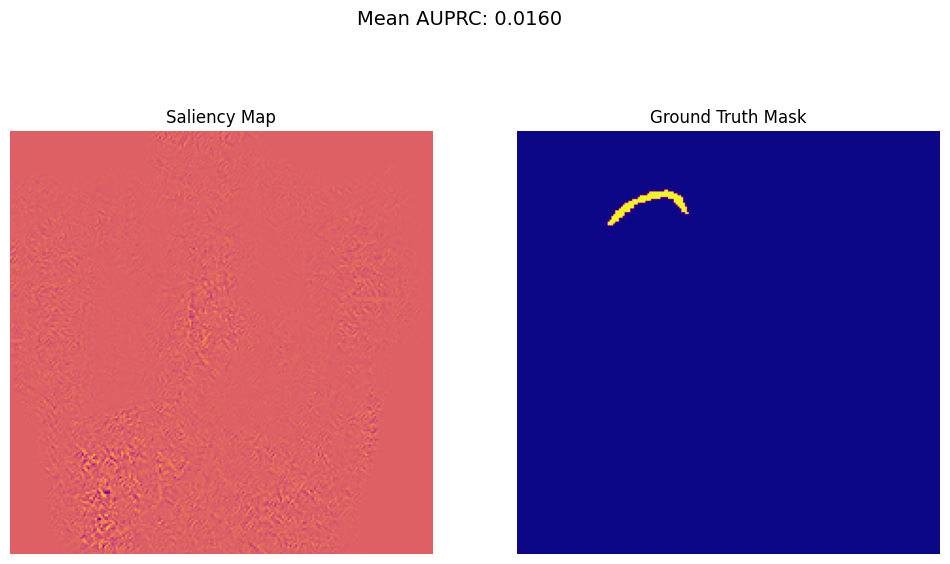

Mean AUPRC (IG): 0.016026320094853407
Standard Deviation (SD) AUPRC (IG): 0.016786147544668766

Technique Folder: Smooth IG


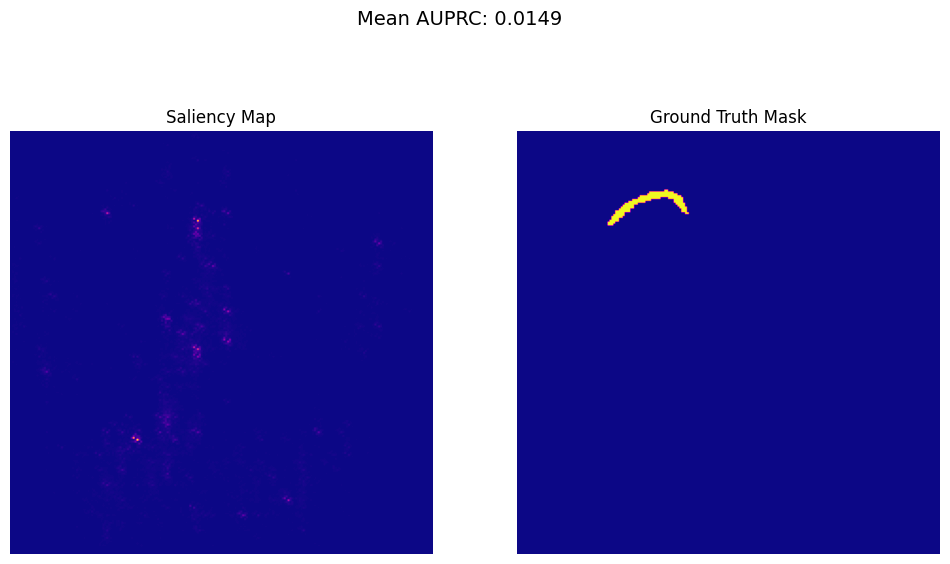

Mean AUPRC (Smooth IG): 0.014900102599684866
Standard Deviation (SD) AUPRC (Smooth IG): 0.016663961510500386

Technique Folder: Guided Backprop


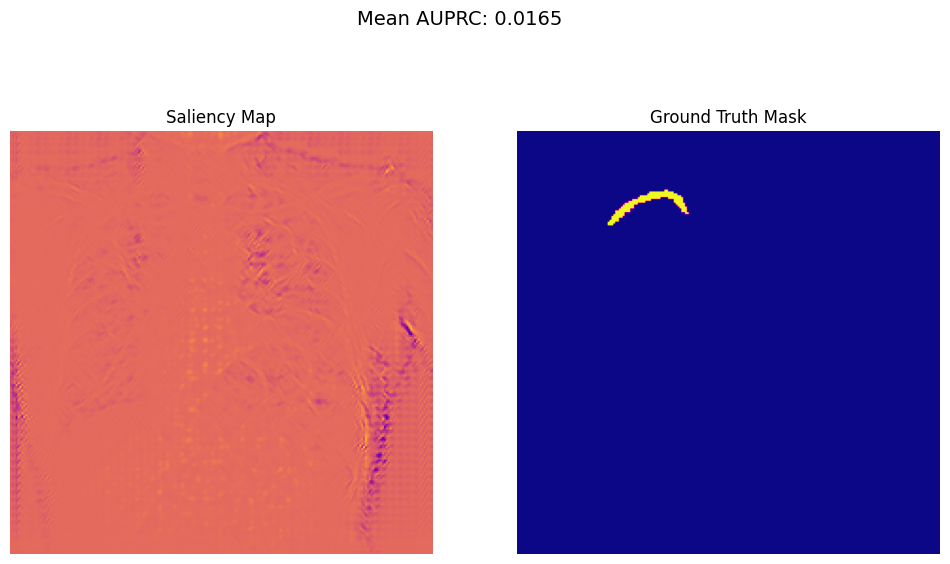

Mean AUPRC (Guided Backprop): 0.01646125700485878
Standard Deviation (SD) AUPRC (Guided Backprop): 0.0175680338759301



In [18]:

import warnings

# Store the results in a list of dictionaries
results_list = []

# Loop through each technique folder
for technique_folder in technique_folders:
    #if technique_folder == "XRAI":
    #    print(f"Skipping {technique_folder} folder...")
    #    continue  # Skip the "XRAI" folder and move to the next folder

    print(f"Technique Folder: {technique_folder}")

    # Use warnings to suppress the deprecation warning messages
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        # Define paths to the folders containing the saliency maps and ground truth masks for this technique
        saliency_maps_folder = os.path.join(parent_dir, technique_folder)
        ground_truth_masks_folder = "/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/images_png/PNG/mask"

        auprc_list = []

       # Loop through patients in the current folder
        for idx, row in tqdm(df_positive.iterrows(), desc='Processing Patients', total=len(df_positive), leave=False):
            label = row['patientId']
            saliency_map = load_saliency_map(os.path.join(saliency_maps_folder, f"{label}_saliency_map.pt"))
            ground_truth_mask = load_ground_truth(ground_truth_masks_folder, label)

            #auprc_val = auprc(saliency_map.cpu(), ground_truth_mask)
            auprc_val = auprc(saliency_map, ground_truth_mask)  # Calculate AUPRC using CPU tensor
            auprc_list.append(auprc_val)

        # Calculate the mean AUPRC and standard deviation (SD) across all labels for this technique
        mean_auprc = np.mean(auprc_list)
        std_auprc = np.std(auprc_list)

        results_folder = '/content/drive/MyDrive/Saliency Map Research 2023/Utility/Results/Pneumothorax Resnet'

        # Save the mean_auprc result in a text file
        mean_results_file_path = os.path.join(results_folder, f"{technique_folder}_mean_auprc.txt")
        with open(mean_results_file_path, 'w') as file:
            file.write(f"Mean AUPRC: {mean_auprc}")

        # Save the std_auprc result in a text file
        std_results_file_path = os.path.join(results_folder, f"{technique_folder}_std_auprc.txt")
        with open(std_results_file_path, 'w') as file:
            file.write(f"Standard Deviation (SD) AUPRC: {std_auprc}")

        # Display an example of the saliency map with the ground truth mask
        example_idx = 0  # Change this index to show a different example if needed
        display_images(saliency_map, ground_truth_mask, mean_auprc)

        print(f"Mean AUPRC ({technique_folder}):", mean_auprc)
        print(f"Standard Deviation (SD) AUPRC ({technique_folder}):", std_auprc)
        print()  # Add an empty line for better readability between techniques


In [40]:
saliency_map_path = (os.path.join(saliency_maps_folder, f"{label}_saliency_map.pt"))
saliency_map_path

'/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/Guided GradCAM/1.2.276.0.7230010.3.1.4.8323329.1532.1517875168.249415_saliency_map.pt'

In [ ]:
'/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Dense (Tensor)/ScoreCAM/1.2.276.0.7230010.3.1.4.8323329.11549.151787523_saliency_map.pt'